# Collect & plot ML performance metrics

This notebook allows you to reproduce Figure 1 of our paper.  
The notebook also saves the performance metrics, which can be used by [another notebook](compute-significance-and-compare-amount-of-variation.ipynb) to compute statistical significance (Table 2) and compare the amount of coarse variation to the amount of granular variation.

In [23]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import time
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.impute import SimpleImputer
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from tqdm import tqdm

# Add preprocessing & analysis folder to path, to import necessary Python helpers
# Please edit the paths to match your local file structure
import sys
sys.path.insert(0, '/home/rm868/granular-race-disparities_MLHC23/preprocessing')
sys.path.insert(0, '/home/rm868/granular-race-disparities_MLHC23/analysis')
from helpers import vitals_valid_range
from paths import data_path, results_path

from race_categories import coarse_races, granular_to_coarse, granular_abbrev, coarse_to_granular
from utils_plotting_metrics import evaluate_calibration

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

import datetime
yearmonthday = datetime.datetime.now().strftime("%Y%m%d")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

We load the data here, and also store the columns corresponding to vital signs for later imputation.
  
Some of the vital values are missing (or were removed during data processing due to outlier values).  
Vitals will be imputed on the training set using the median values which *are* present, and then the imputed medians will also be applied to the test set. (To maintain train/test hygiene, the medians do not include the values from the test set.)

In [14]:
df = pd.read_csv(os.path.join(data_path, 'main_ed_dataset.csv'))
print("Total number of ED visits:", df.shape[0])
print("Total number of patients:", df.subject_id.nunique())


Total number of ED visits: 418100
Total number of patients: 201252


In [ ]:
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

features = ["age", 
            "gender_M", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcomes = ['outcome_hospitalization', 'outcome_critical', 'outcome_ed_revisit_3d']

# Define vitals cols for later imputation.
vitals_cols = [col for col in df.columns if len(col.split('_')) > 1 and 
                                                col.split('_')[1] in vitals_valid_range and
                                                col.split('_')[1] != 'acuity']
imputer = SimpleImputer(strategy = 'median')

display(df.head())

## Collect performance metrics for logistic regression

Separate logistic regressions will be trained to predict each of the three outcomes, using the same feature set for all three outcomes. (Note that this differs slightly from Xie et al., who use an additional length-of-stay feature to predict ED revisits.)  

For FPR and FNR, we need thresholds to define predictions as positive or negative. We use the thresholds from Xie et al. (https://www.nature.com/articles/s41597-022-01782-9).

Note that we use a very high testing fraction (70% of the data), (1) to improve statistical power when comparing performance metrics for the granular groups, which are relatively small; and (2) because the model's weights/accuracy did not change after 30% of the data.

In [18]:
train_frac = 0.30
test_frac = 0.70

# The number of train/test reshuffles to compute performance over.
# In the paper, we used 1000, which takes about 5 hours to run (without parallelization).
N_trials = 50 

# Default max iterations for logistic regression
max_iter = 100

# Optimal thresholds from paper
paper_thresholds = {
    'outcome_hospitalization': 0.446,
    'outcome_critical': 0.064,
    'outcome_ed_revisit_3d': 0.041,
}

# To ensure train/test hygiene, we will split on subjects, not visits.
# This way no patient in the test set will have been seen in the train set.
# (Note that this differs from Xie et al., who split on visits, not subjects.)
unique_ids = df.subject_id.unique()
def get_train_test_subject_split(seed, train_frac=train_frac):
    np.random.seed(seed)
    train_ids = np.random.choice(unique_ids, int(train_frac*len(unique_ids)), replace=False)
    df_train = df[df.subject_id.isin(train_ids)].copy()
    df_test = df.drop(df_train.index)
    return df_train, df_test

In [25]:
metrics = ['auroc', 'auprc', # standard classification metrics
           'fpr', 'fnr', # fpr and fnr with the thresholds they give in paper
           'ece', # 10-bin ECE
          ]

ece_bin_count = 10 # Number of bins to compute ECE over

coarse_metrics = {f'{race}_{outcome}_{metric}': [] for race in coarse_races for outcome in outcomes for metric in metrics}
granular_metrics = {f'{race}_{outcome}_{metric}': [] for race in granular_to_coarse for outcome in outcomes for metric in metrics}

In [26]:
start = time.time()
for i in tqdm(range(N_trials), miniters=10):
    # Sample train/test sets according to specified fractions
    df_train, df_test = get_train_test_subject_split(seed=i)
    
    # Fit the imputer on the median values from train, apply to test
    df_train[vitals_cols] = imputer.fit_transform(df_train[vitals_cols])
    df_test[vitals_cols] = imputer.transform(df_test[vitals_cols])
    for (j, outcome) in enumerate(outcomes):
        y_true_train = df_train[outcome]
        y_true_test = df_test[outcome]
        lr = LogisticRegression()
        
        lr.fit(df_train[features], y_true_train)
        y_pred_test = lr.predict_proba(df_test[features])[:, 1]
        
        # Classification threshold from the paper
        threshold_paper = paper_thresholds[outcome]
        
        # Compute metrics for coarse groups
        for race in coarse_races:
            race_idxs = (df_test.coarse_race == race)
            # Get coarse auroc, auprc
            auroc = roc_auc_score(y_true_test[race_idxs], y_pred_test[race_idxs])
            auprc = average_precision_score(y_true_test[race_idxs], y_pred_test[race_idxs])
            
            # Get coarse FPR and FNR using paper thresholds
            preds_fixed_threshold = (y_pred_test[race_idxs] > threshold_paper).astype(int)
            (tn, fp, fn, tp) = confusion_matrix(y_true_test[race_idxs], preds_fixed_threshold).flatten()
            fpr_fixed = fp / (fp + tn)
            fnr_fixed = fn / (fn + tp)
            
            # Add all metrics to the dict
            coarse_metrics[f'{race}_{outcome}_auroc'].append(auroc)
            coarse_metrics[f'{race}_{outcome}_auprc'].append(auprc)
            coarse_metrics[f'{race}_{outcome}_fpr'].append(fpr_fixed)
            coarse_metrics[f'{race}_{outcome}_fnr'].append(fnr_fixed)

            calibration = evaluate_calibration(y_pred_test[race_idxs], y_true_test[race_idxs], ece_bin_count)
            coarse_metrics[f'{race}_{outcome}_ece'].append(calibration)
            
        # Compute metrics for granular groups
        for race in granular_to_coarse:
            race_idxs = (df_test.granular_race == race)
            
            # If, due to chance, there are no patients sampled in this granular group, add NaNs and skip
            if np.all(y_true_test[race_idxs] == 0):
                print(race, outcome, race_idxs.sum())
                granular_metrics[f'{race}_{outcome}_auroc'].append(np.nan)
                granular_metrics[f'{race}_{outcome}_auprc'].append(np.nan)
                granular_metrics[f'{race}_{outcome}_fpr'].append(np.nan)
                granular_metrics[f'{race}_{outcome}_fnr'].append(np.nan)
                granular_metrics[f'{race}_{outcome}_ece'].append(np.nan)
                continue
            
            # Get granular auroc, auprc
            auroc = roc_auc_score(y_true_test[race_idxs], y_pred_test[race_idxs])
            auprc = average_precision_score(y_true_test[race_idxs], y_pred_test[race_idxs])
            
            # Get granular FPR and FNR using paper thresholds
            preds_fixed_threshold = (y_pred_test[race_idxs] > threshold_paper).astype(int)
            (tn, fp, fn, tp) = confusion_matrix(y_true_test[race_idxs], preds_fixed_threshold).flatten()
            fpr_fixed = fp / (fp + tn)
            fnr_fixed = fn / (fn + tp)
            
            # Add all metrics to the dict
            granular_metrics[f'{race}_{outcome}_auroc'].append(auroc)
            granular_metrics[f'{race}_{outcome}_auprc'].append(auprc)
            granular_metrics[f'{race}_{outcome}_fpr'].append(fpr_fixed)
            granular_metrics[f'{race}_{outcome}_fnr'].append(fnr_fixed)
            
            calibration = evaluate_calibration(y_pred_test[race_idxs], y_true_test[race_idxs], ece_bin_count)
            granular_metrics[f'{race}_{outcome}_ece'].append(calibration)
    
runtime = time.time() - start
print(f"Total runtime: {runtime:.3f}s")

  0%|                                                                                                                                                      | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:27<00:00, 11.35s/it]

Total runtime: 567.555s


In [30]:
with open(os.path.join(results_path, f'logisticregression_coarse_metrics_{N_trials}_{yearmonthday}.pkl'), 'wb') as out:
    pickle.dump(coarse_metrics, out)

with open(os.path.join(results_path, f'logisticregression_granular_metrics_{N_trials}_{yearmonthday}.pkl'), 'wb') as out:
    pickle.dump(granular_metrics, out)

## Create pointplots with granular group performances

Plot results in the form of Figure 1 in the paper for each of the four metrics. Within each metric, plot results for all three outcomes.

In [42]:
N_trials = 50
yearmonthday = '20230823'

# Load results from pickle if necessary
with open(os.path.join(results_path, f'logisticregression_coarse_metrics_{N_trials}_{yearmonthday}.pkl'), 'rb') as f:
    coarse_metrics = pickle.load(f)

with open(os.path.join(results_path, f'logisticregression_granular_metrics_{N_trials}_{yearmonthday}.pkl'), 'rb') as f:
    granular_metrics = pickle.load(f)

# Convert to dataframes
coarse_df = pd.DataFrame(coarse_metrics)
granular_df = pd.DataFrame(granular_metrics)

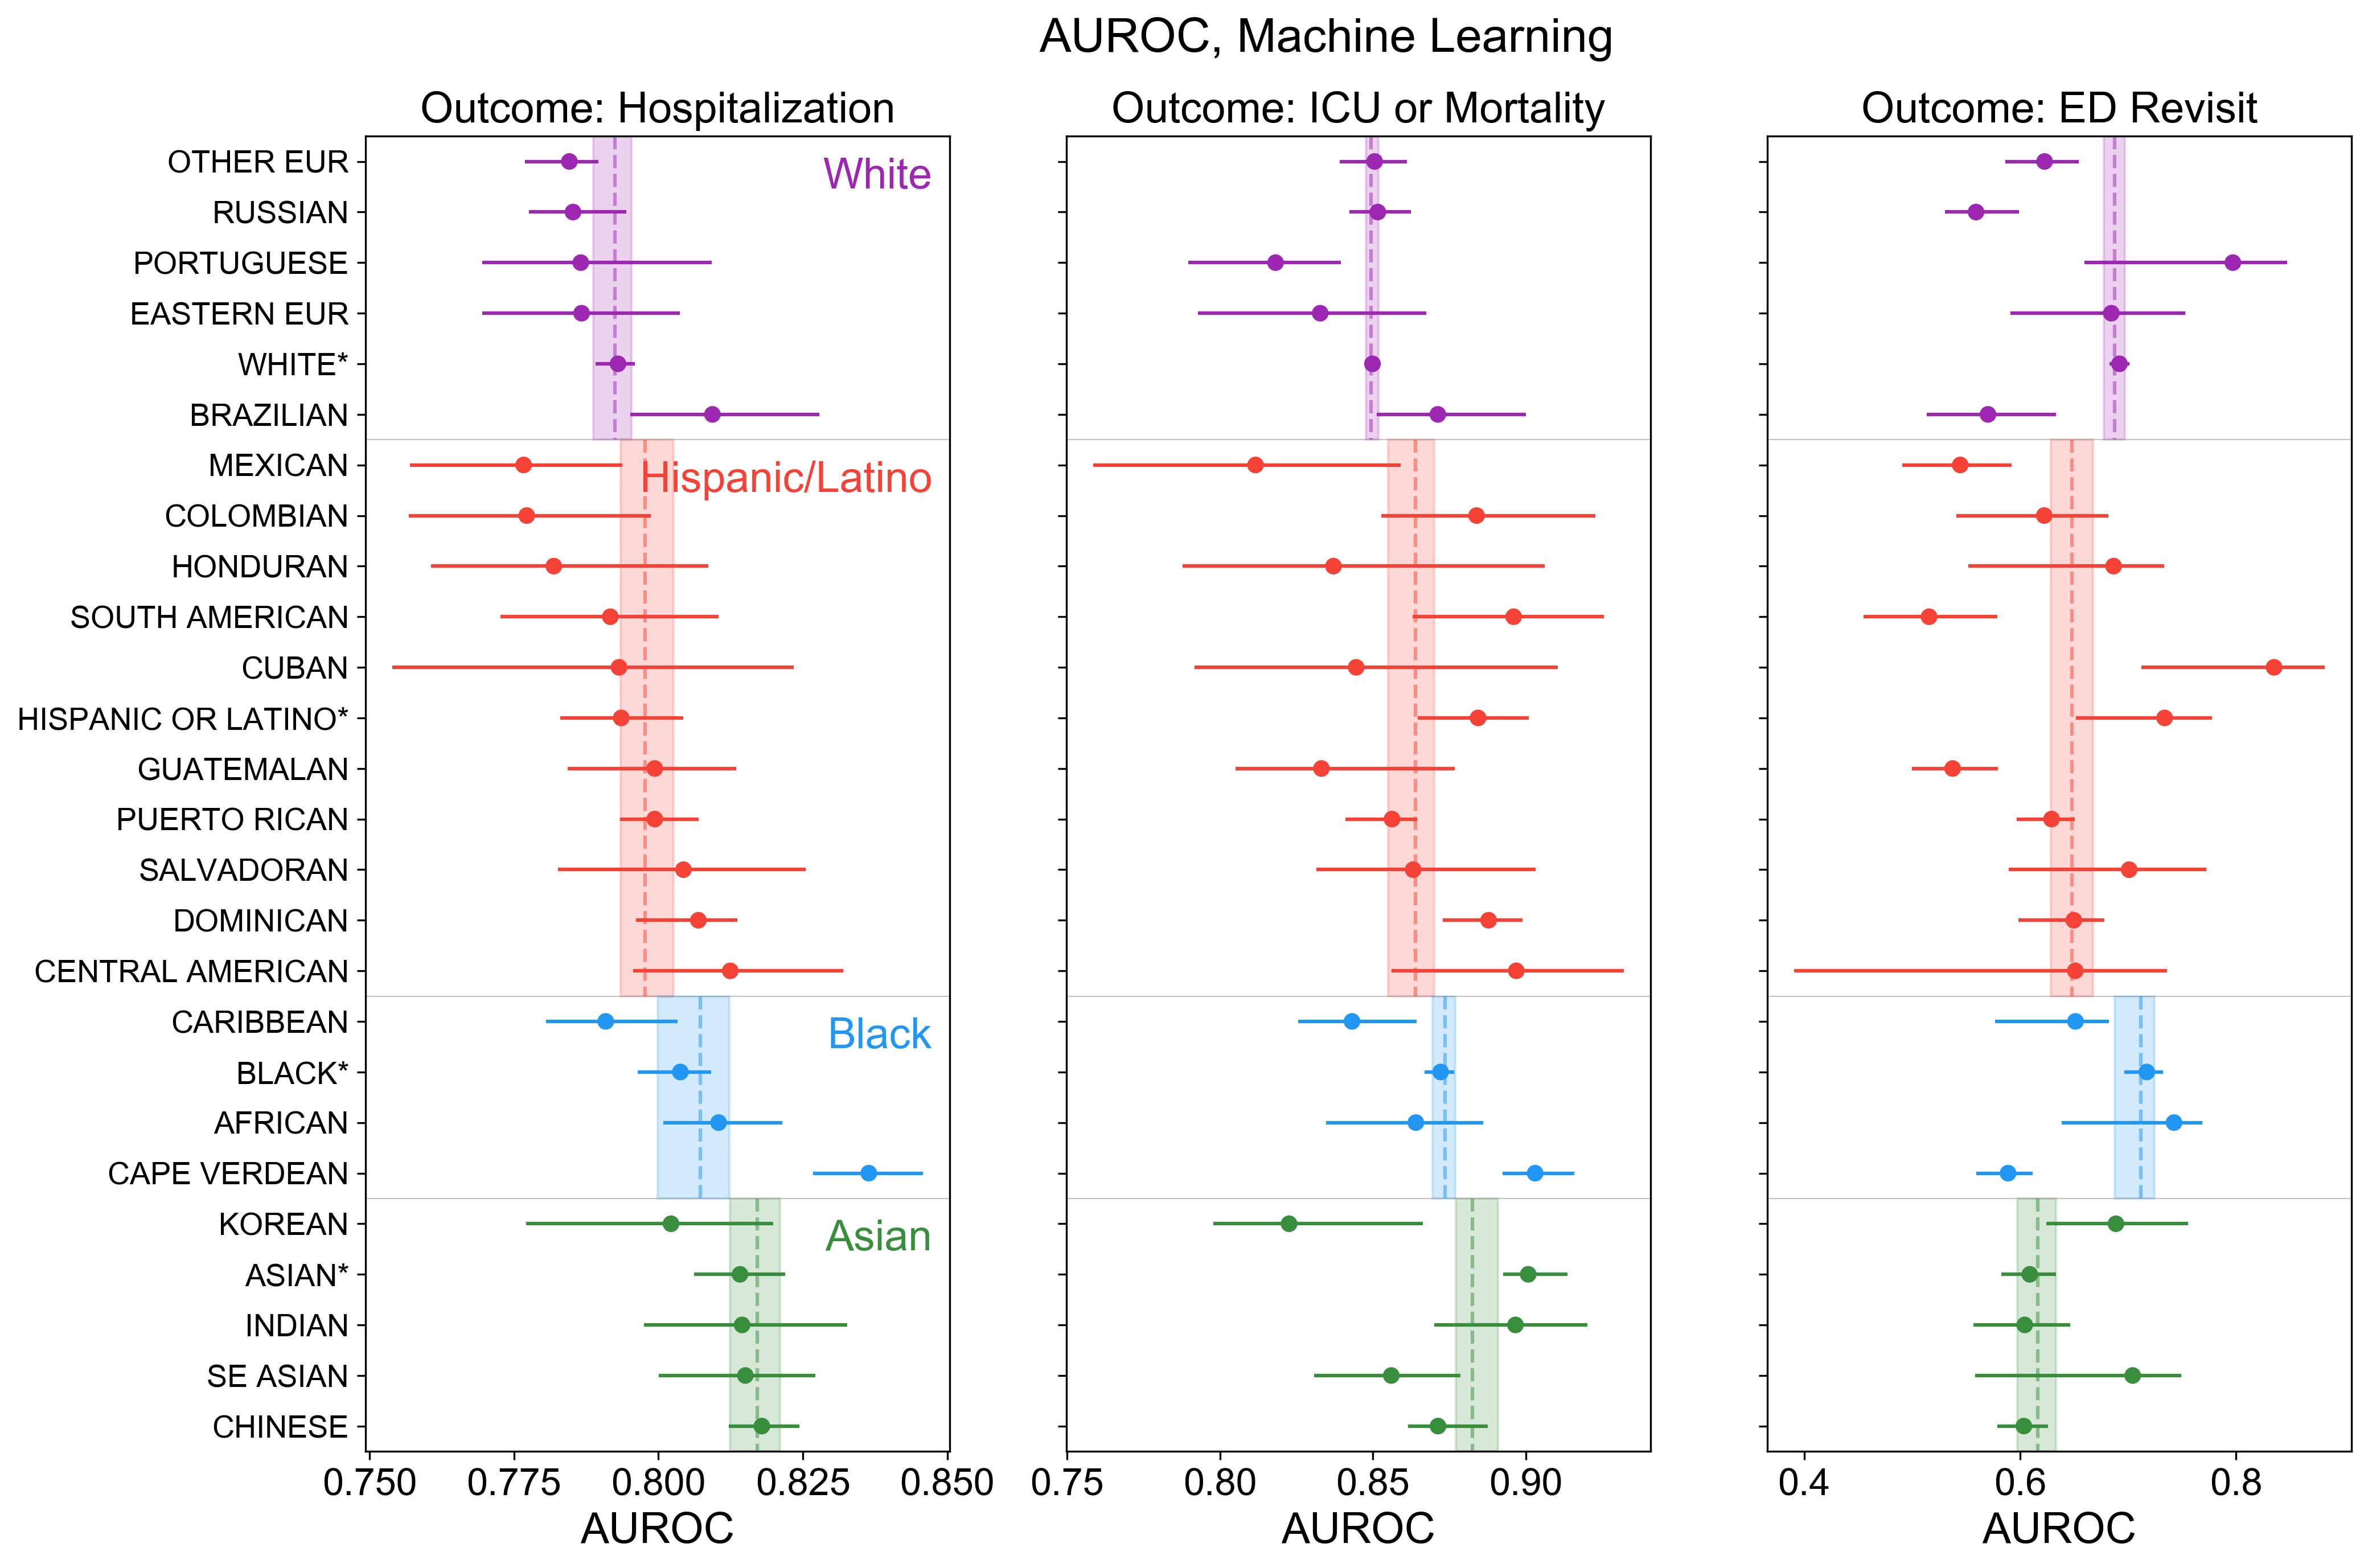

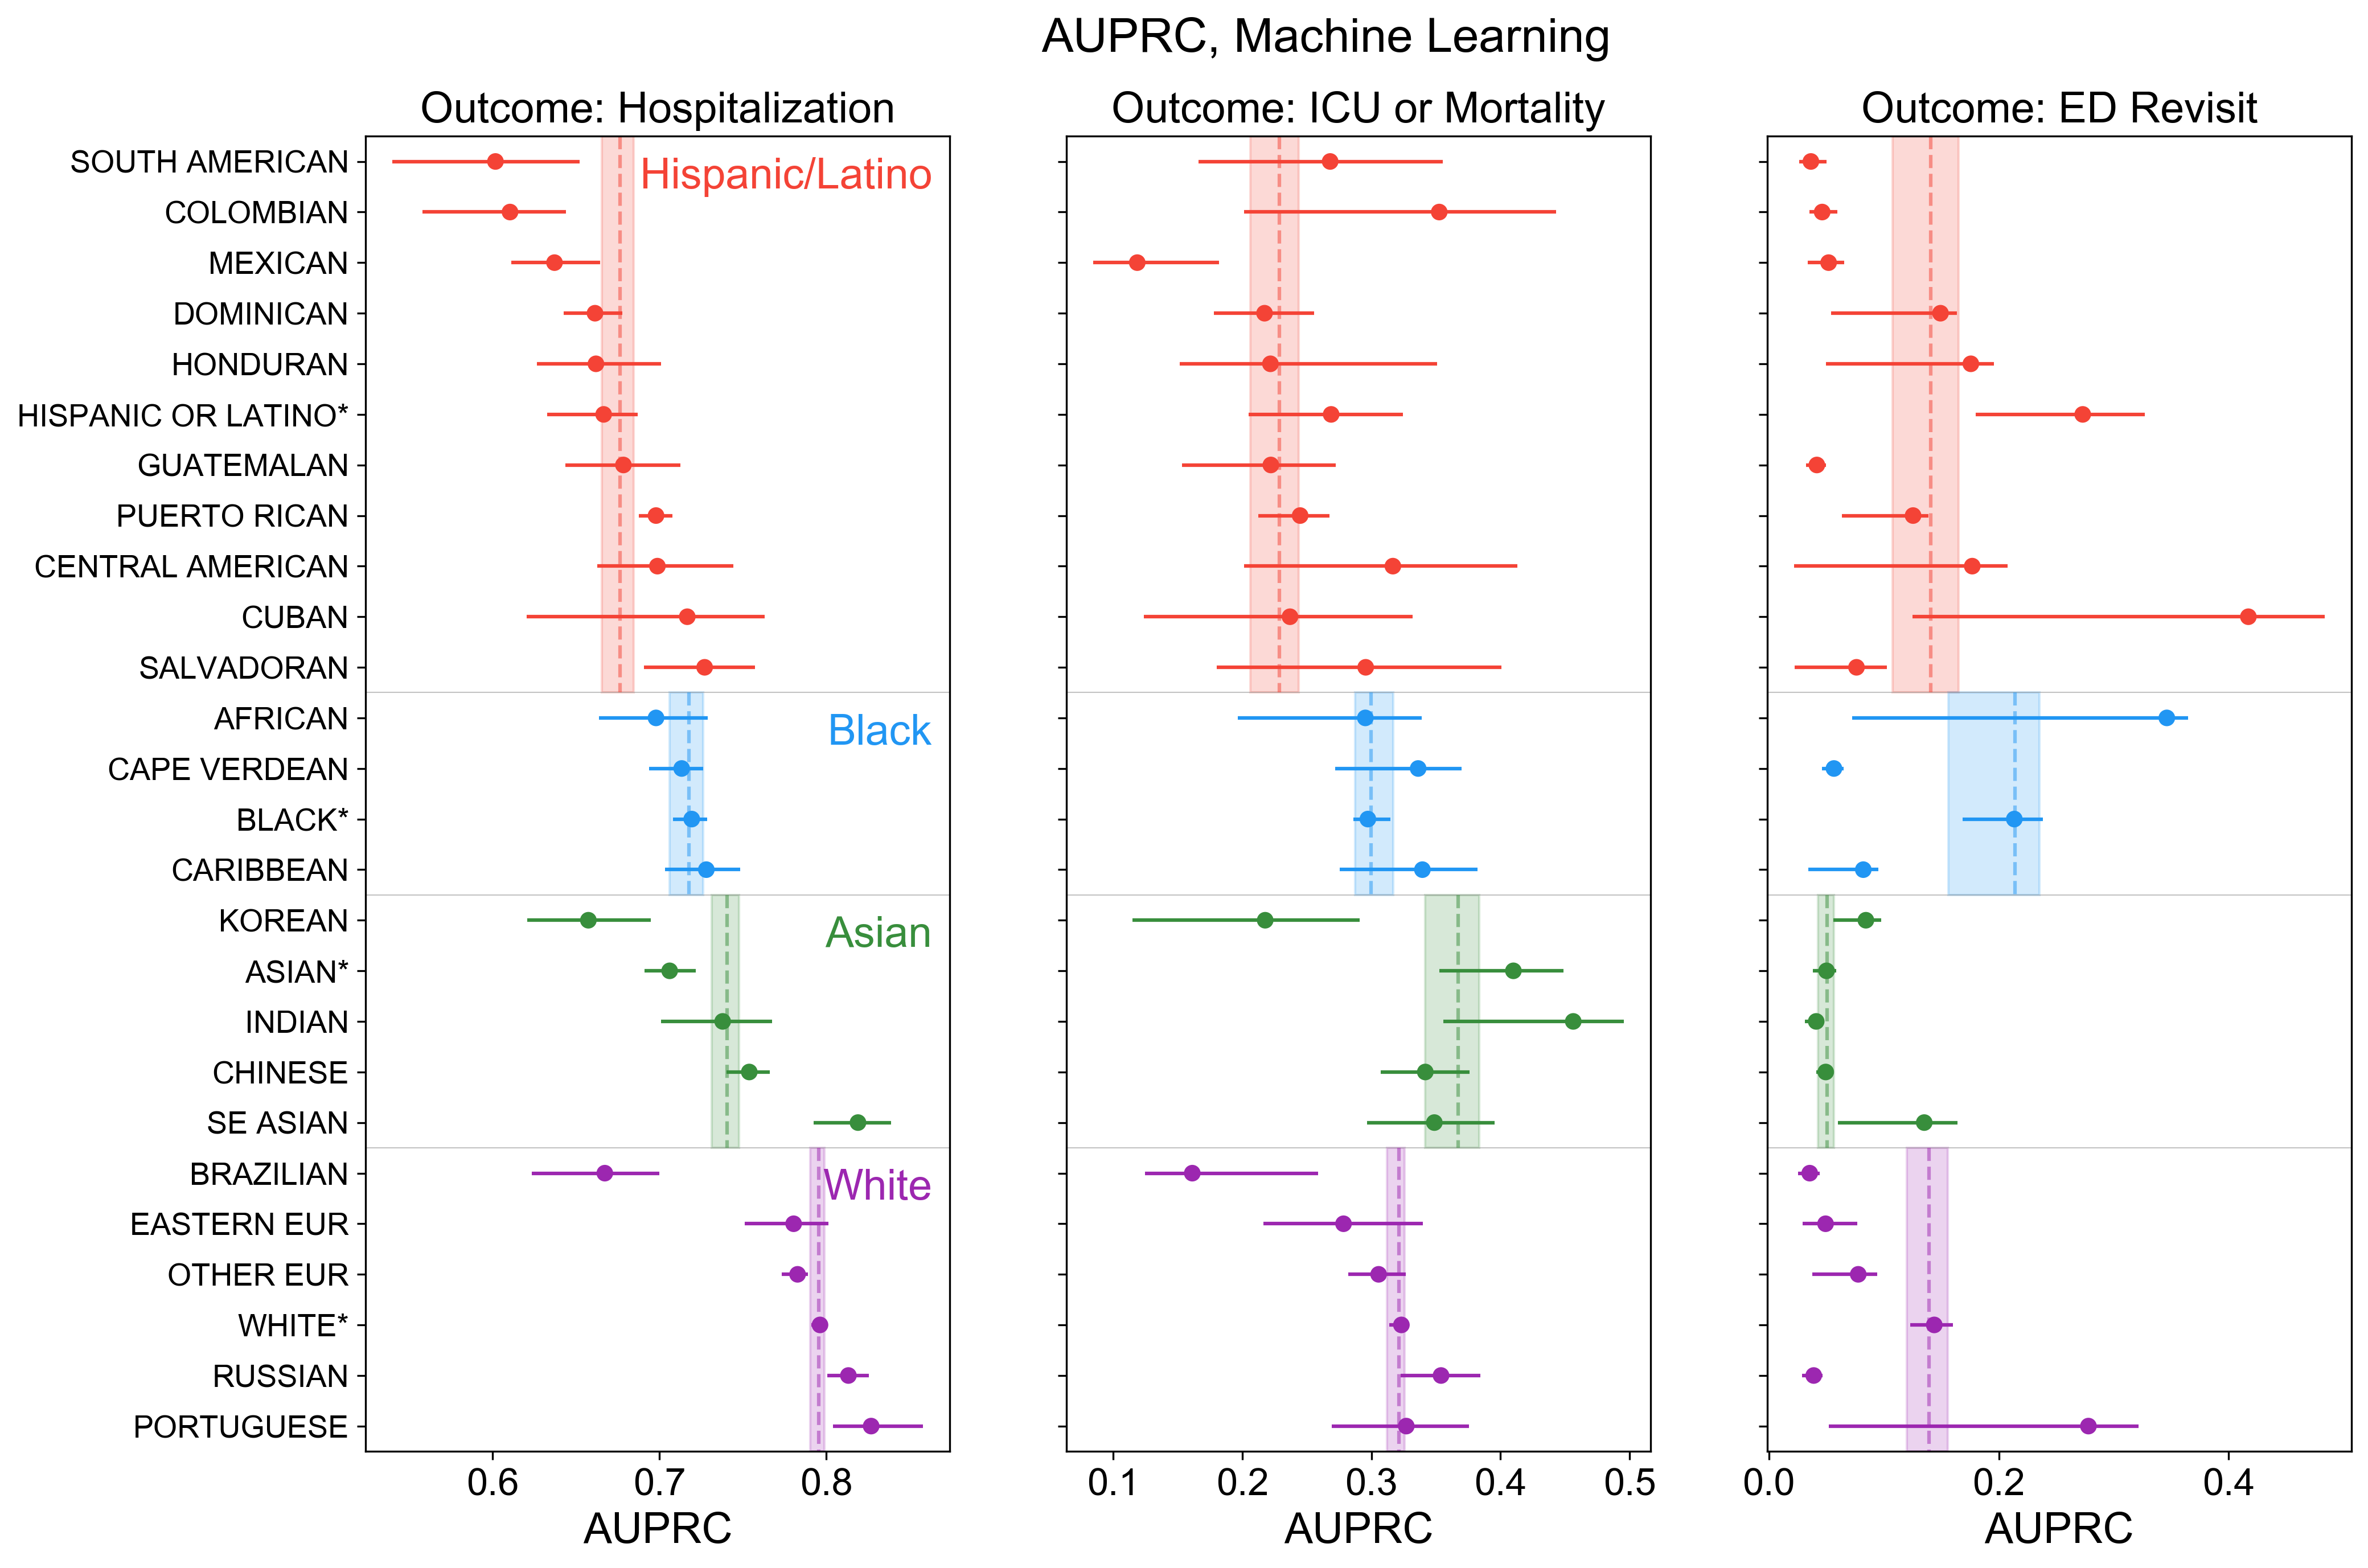

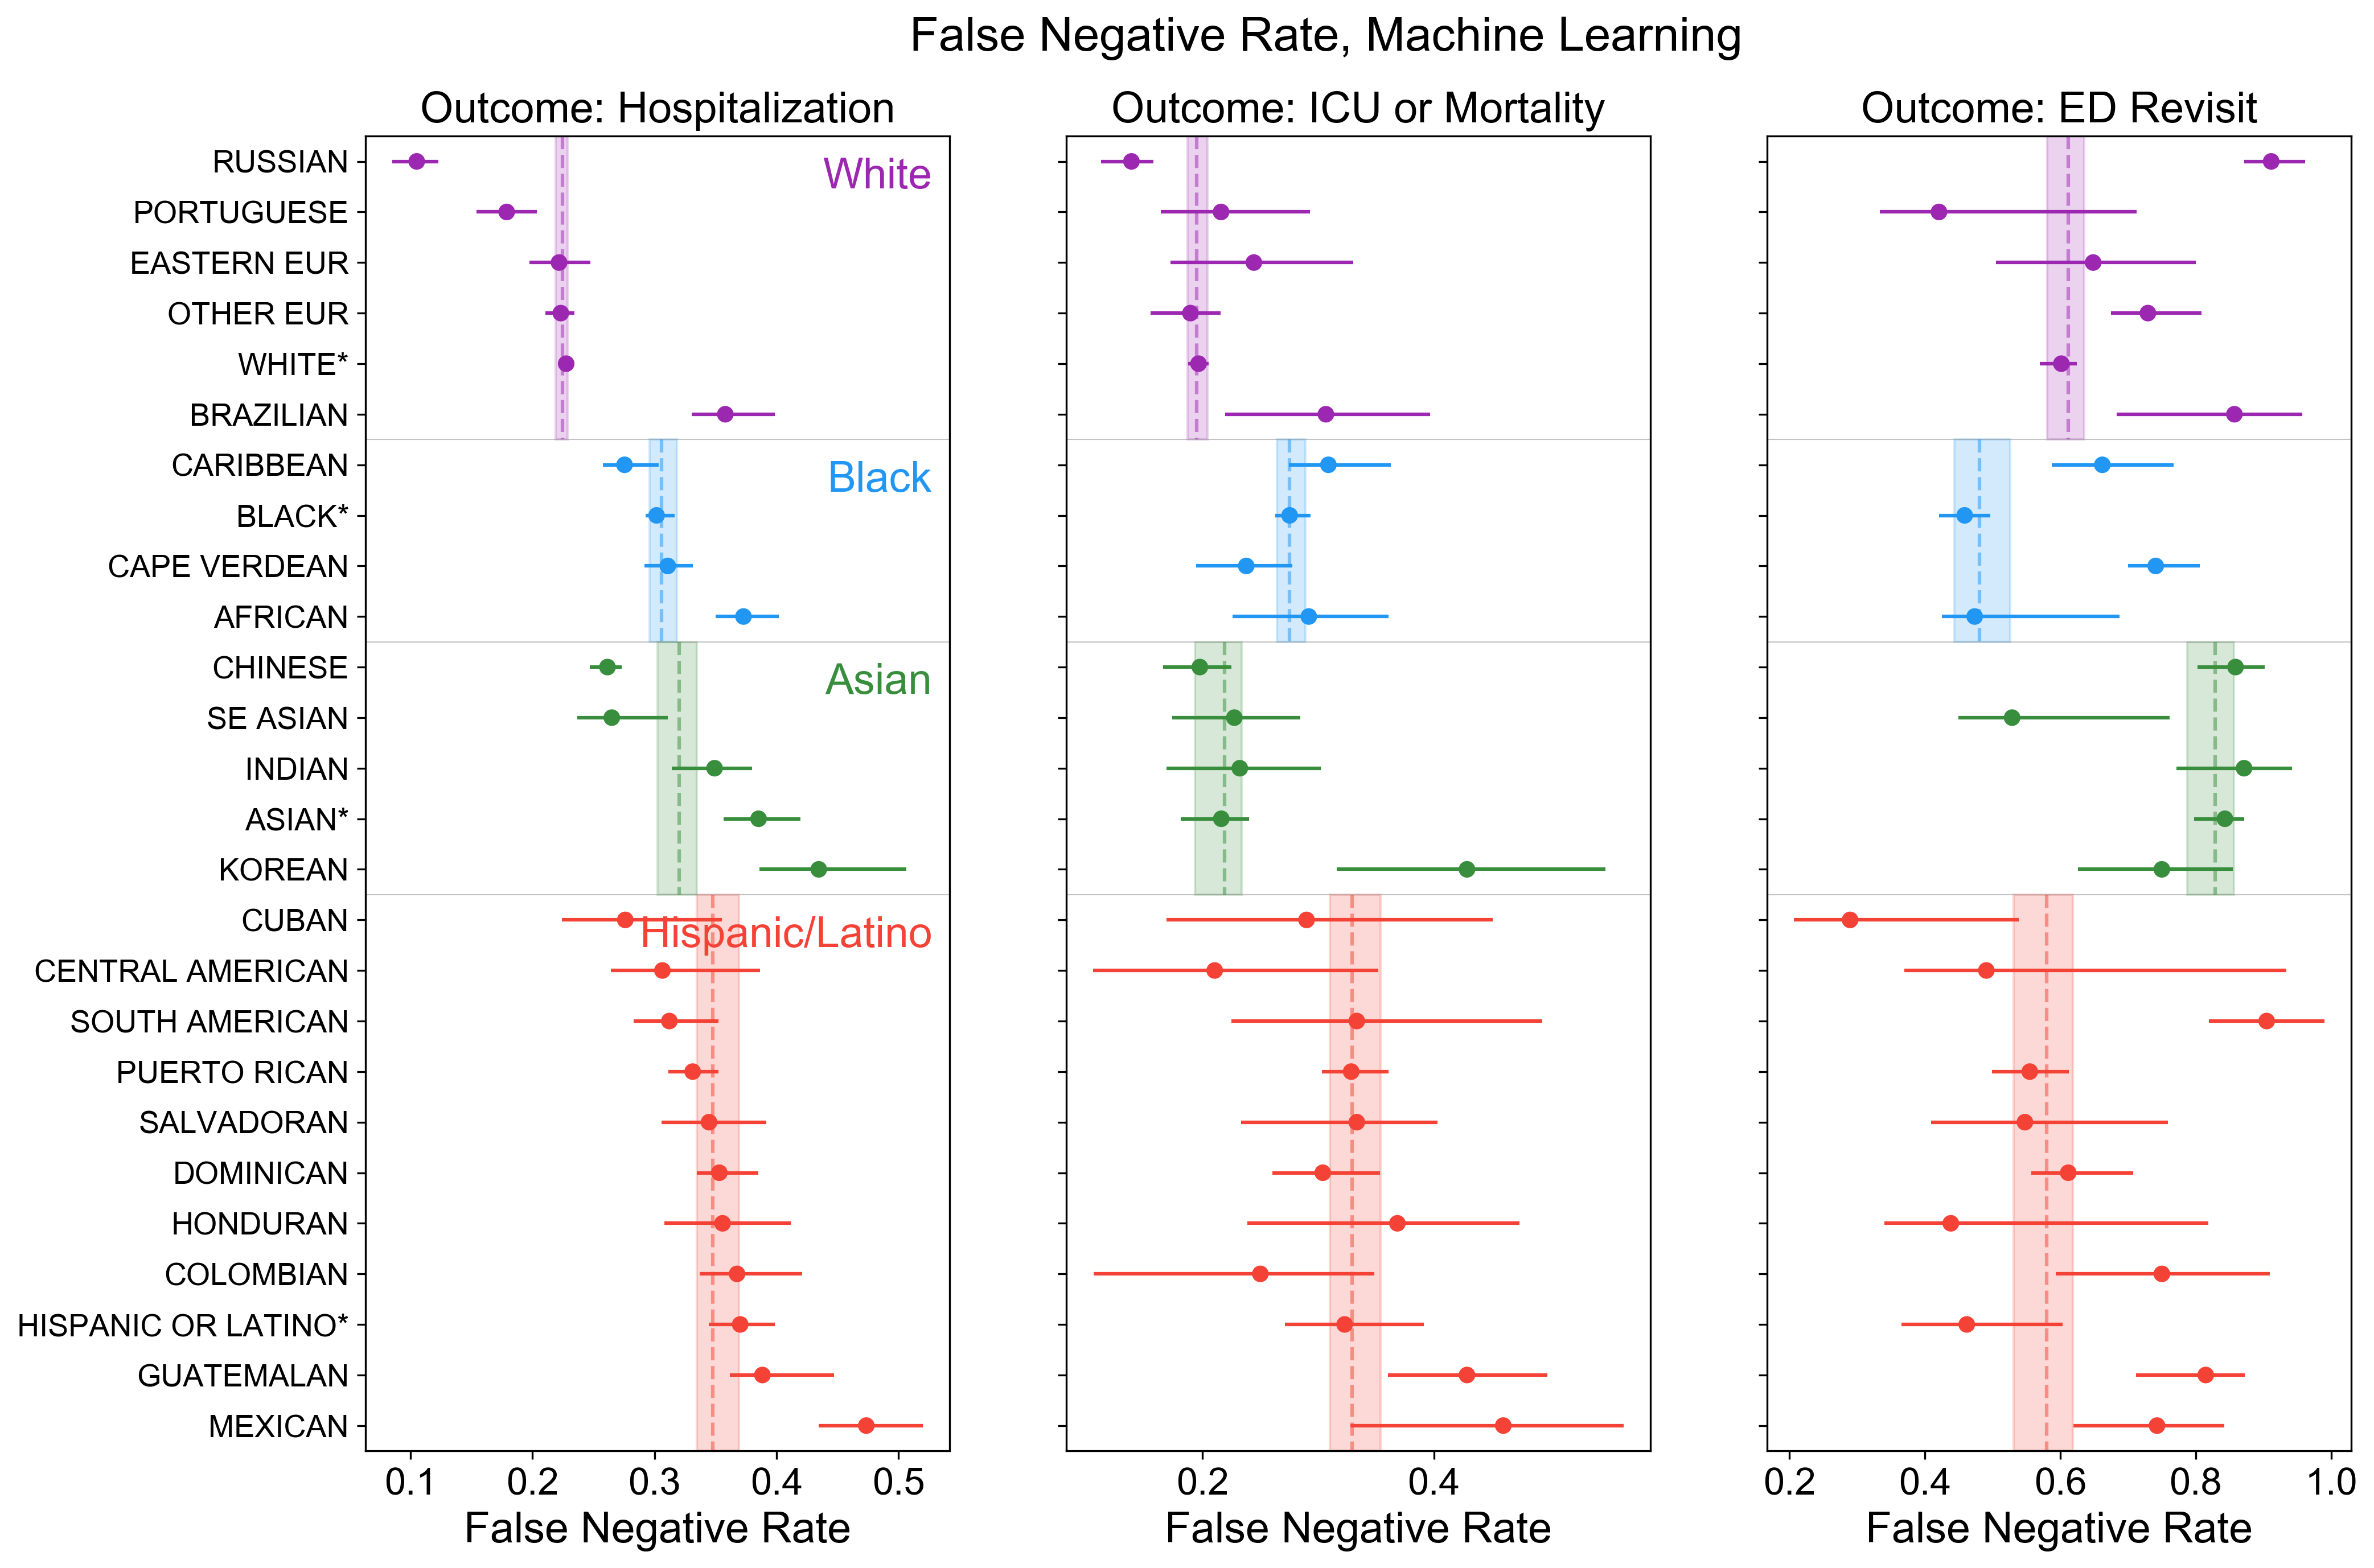

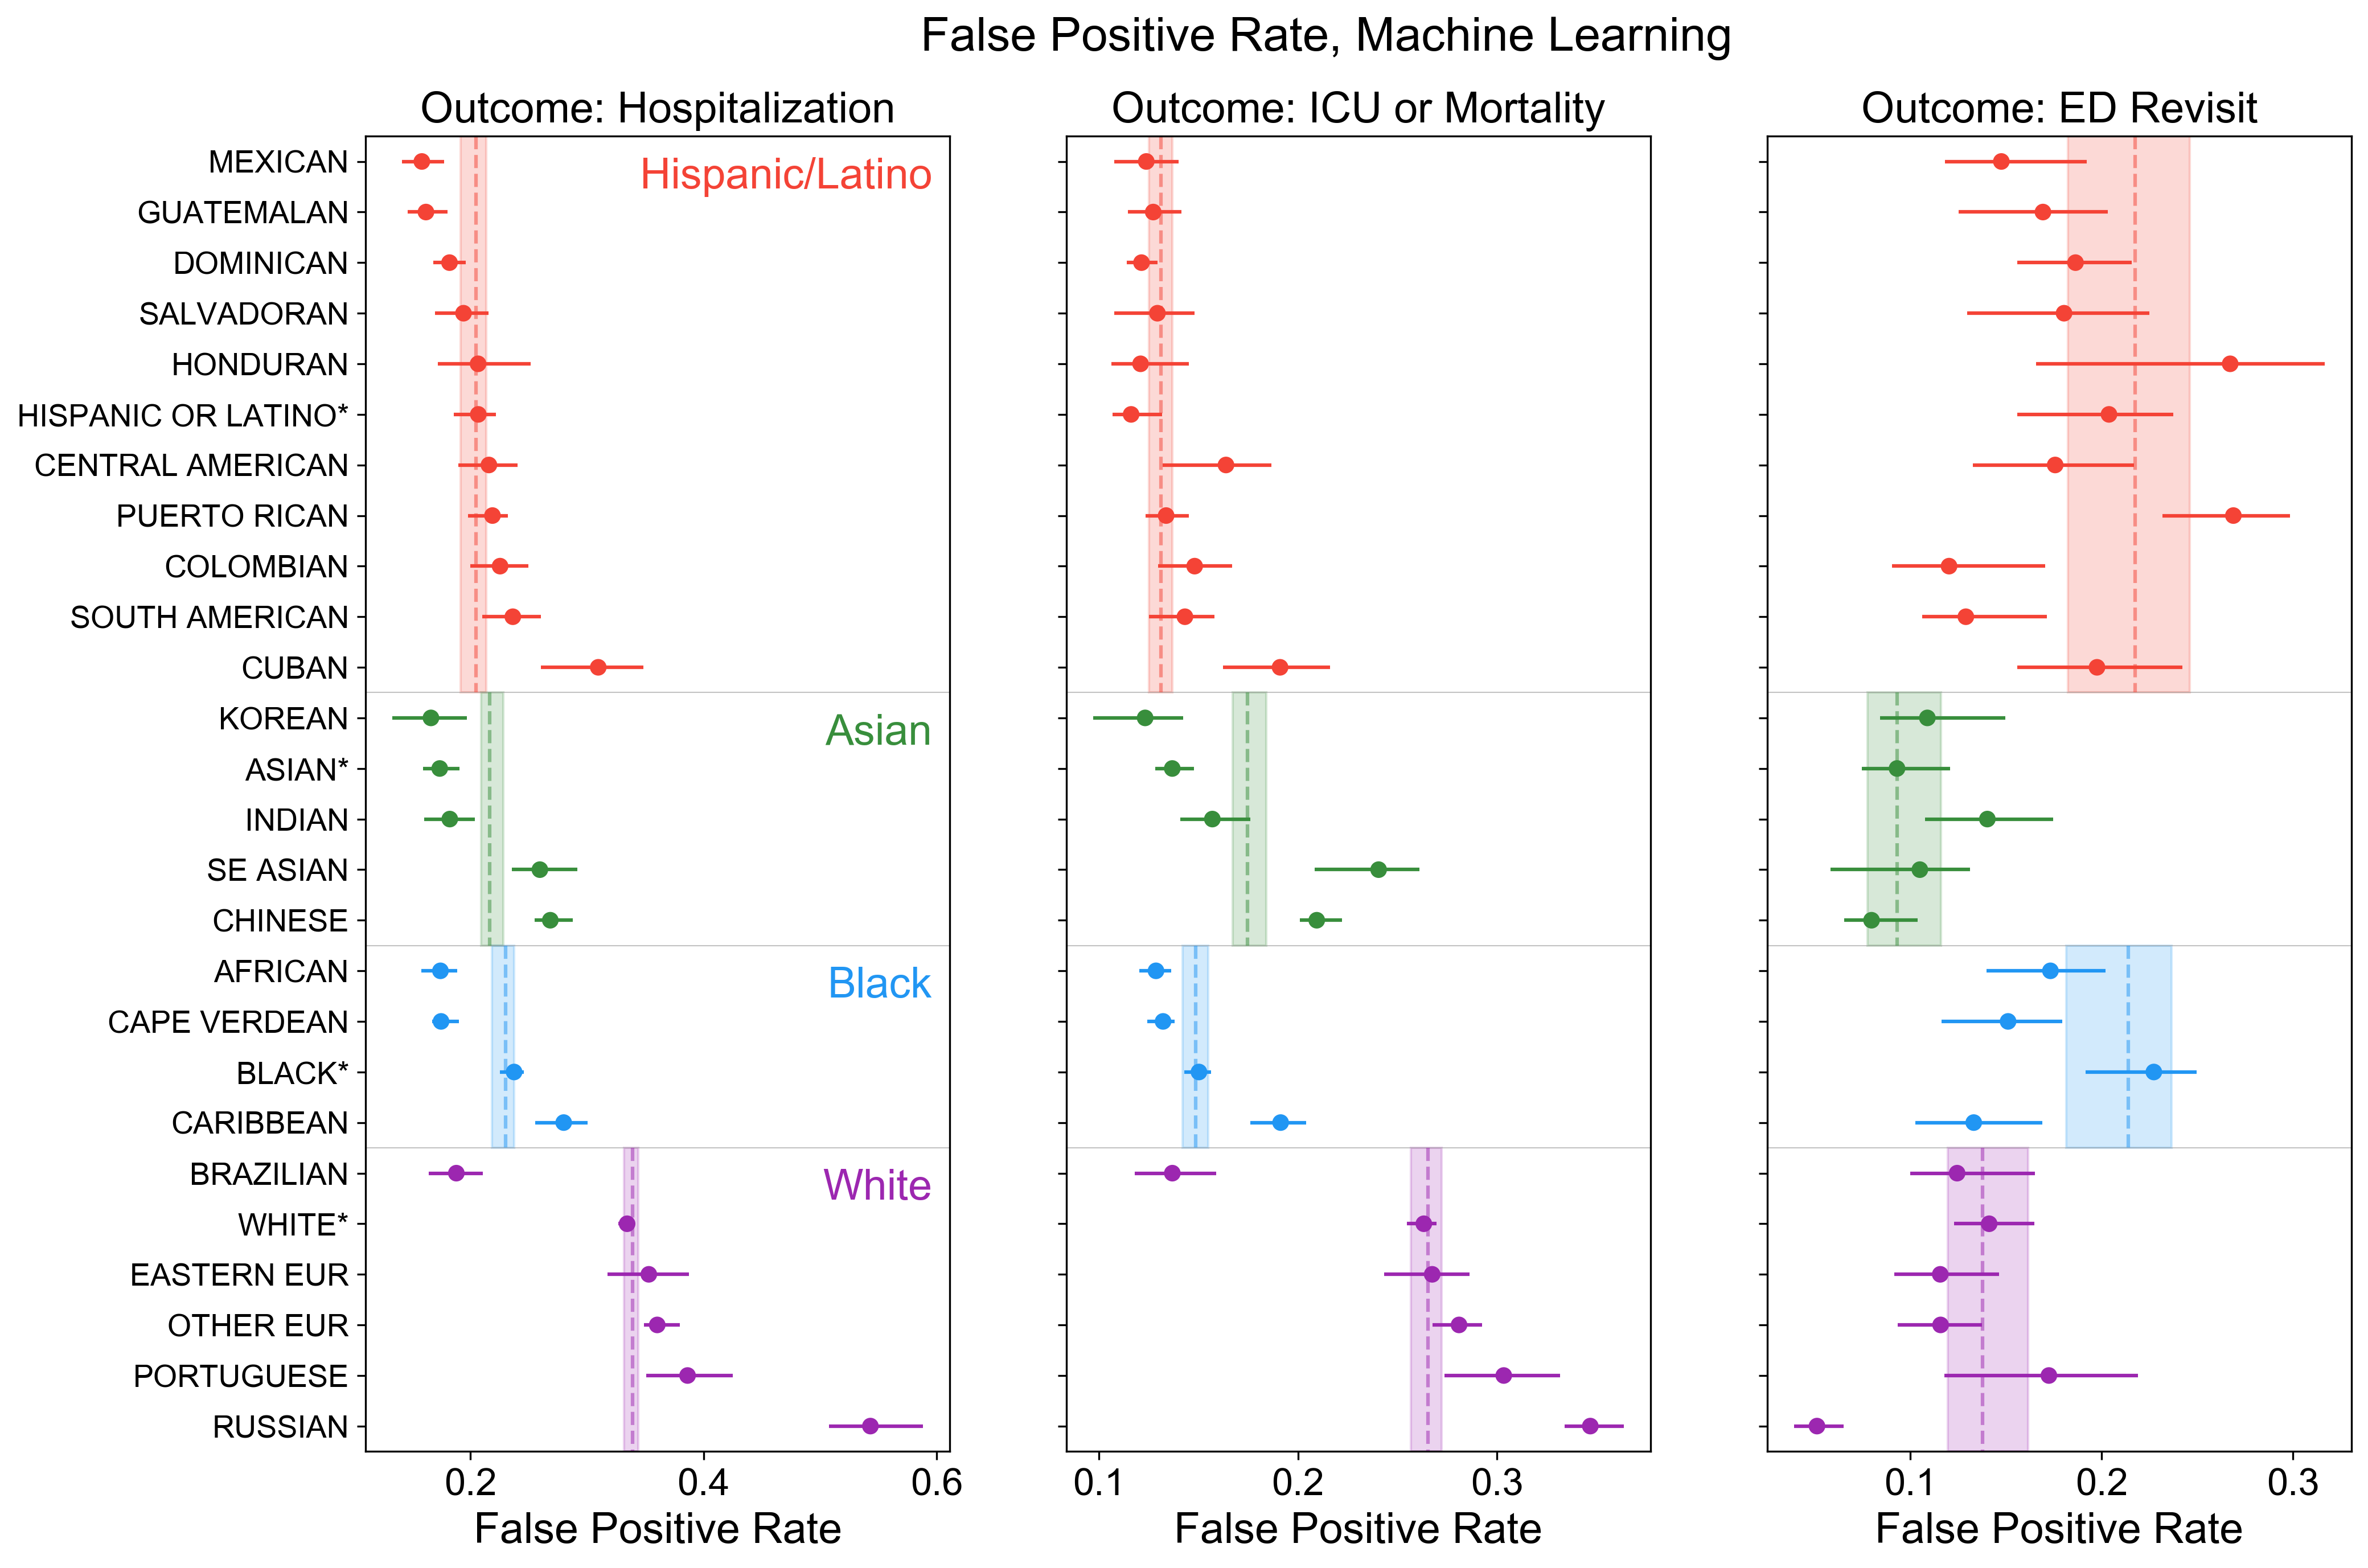

In [48]:
from utils_plotting_metrics import predictive_metrics_pointplot, metrics_to_labels

metrics = ['auroc', 'auprc', 'fnr', 'fpr',]
outcomes = ['outcome_hospitalization', 'outcome_critical', 'outcome_ed_revisit_3d']

for metric in metrics:
    predictive_metrics_pointplot(
        granular_df = granular_df,
        coarse_df = coarse_df,
        metric = metric,
        outcomes = outcomes,
        annot_x = 0.97,
        first_annot_only = True,
        tight_layout = False,
        fontsize_yticks = 13,
        fontsize_xticks = 16,
        fontsize_annot = 18,
        fontsize_xlabel = 18,
        fontsize_title = 18,
        fontsize_suptitle = 20,
        dpi=300,
        figsize = (15, 10),
        suptitle = f'{metrics_to_labels[metric]}, Machine Learning',
    )